**Install & Import Libraries**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


**Dataset Preparation**

In [3]:
# Hyperparameters
batch_size = 128
epochs = 20
latent_dim = 2   # keep 2 for latent space visualization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transform
transform = transforms.ToTensor()

# MNIST Dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 505kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.48MB/s]


**Build the VAE Model**

In [4]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(28*28, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, 400)
        self.fc3 = nn.Linear(400, 28*28)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


**Define Loss Function**

In [5]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(
        recon_x, x, reduction='sum'
    )
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss


**Train the VAE**

In [6]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for data, _ in train_loader:
        data = data.view(-1, 28*28).to(device)

        optimizer.zero_grad()
        recon, mu, logvar = model(data)
        loss = vae_loss(recon, data, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")


Epoch [1/20], Loss: 190.4065
Epoch [2/20], Loss: 167.8314
Epoch [3/20], Loss: 163.8907
Epoch [4/20], Loss: 161.5800
Epoch [5/20], Loss: 159.9331
Epoch [6/20], Loss: 158.8459
Epoch [7/20], Loss: 157.8479
Epoch [8/20], Loss: 157.0940
Epoch [9/20], Loss: 156.4418
Epoch [10/20], Loss: 155.8576
Epoch [11/20], Loss: 155.3348
Epoch [12/20], Loss: 154.8470
Epoch [13/20], Loss: 154.3376
Epoch [14/20], Loss: 153.9263
Epoch [15/20], Loss: 153.5917
Epoch [16/20], Loss: 153.1861
Epoch [17/20], Loss: 152.8356
Epoch [18/20], Loss: 152.4631
Epoch [19/20], Loss: 152.1665
Epoch [20/20], Loss: 151.8904


**Plot Training Loss**

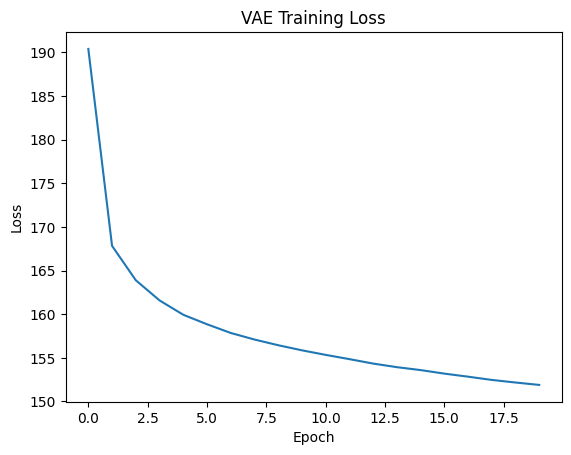

In [7]:
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training Loss")
plt.show()


**Reconstructed Images**

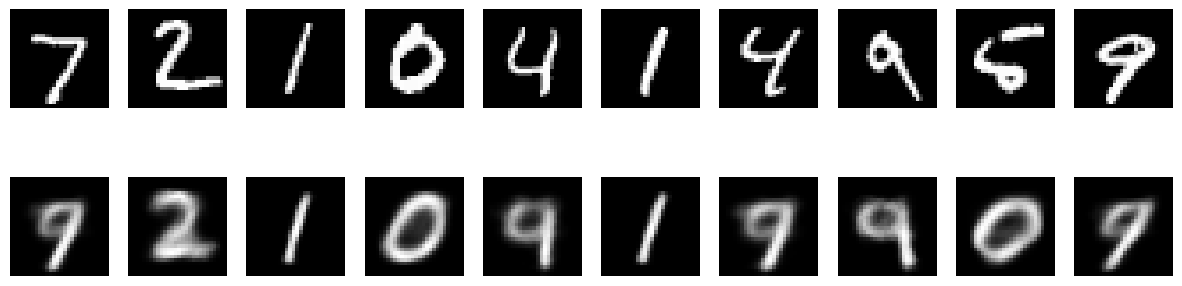

In [8]:
model.eval()
with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data.view(-1, 28*28).to(device)
    recon, _, _ = model(data)

# Plot original vs reconstructed
n = 10
plt.figure(figsize=(15, 4))
for i in range(n):
    # Original
    plt.subplot(2, n, i + 1)
    plt.imshow(data[i].cpu().view(28,28), cmap='gray')
    plt.axis('off')

    # Reconstructed
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon[i].cpu().view(28,28), cmap='gray')
    plt.axis('off')

plt.show()


**Generate New Samples**

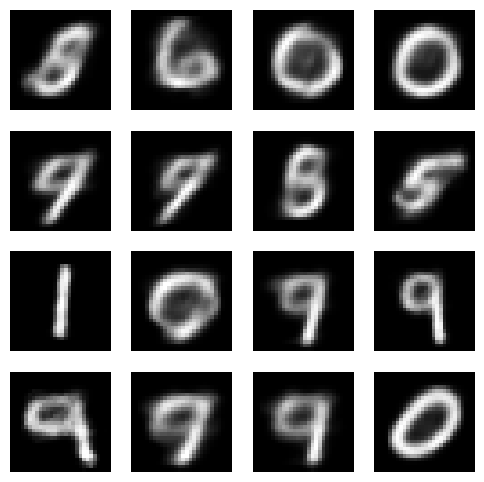

In [9]:
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    samples = model.decode(z).cpu()

plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(samples[i].view(28,28), cmap='gray')
    plt.axis('off')
plt.show()


**Latent Space Visualization**

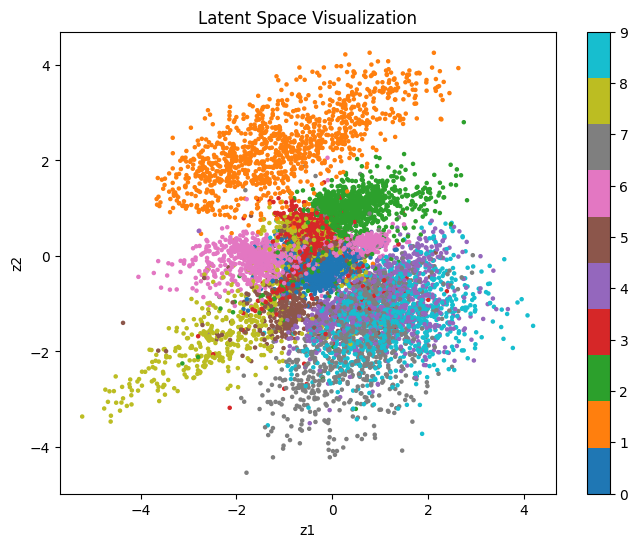

In [10]:
model.eval()
latent_vectors = []
labels = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.view(-1, 28*28).to(device)
        mu, _ = model.encode(data)
        latent_vectors.append(mu.cpu())
        labels.append(target)

latent_vectors = torch.cat(latent_vectors)
labels = torch.cat(labels)

plt.figure(figsize=(8,6))
plt.scatter(latent_vectors[:,0], latent_vectors[:,1], c=labels, cmap='tab10', s=5)
plt.colorbar()
plt.title("Latent Space Visualization")
plt.xlabel("z1")
plt.ylabel("z2")
plt.show()
